### **This notebook compares four regression models (Elastic Net, Lasso, Ridge, and Linear Regresion) as they fit data sourced from the 1970 Boston Housing Market Study**

Google Colab url: https://colab.research.google.com/drive/122DCYs3EQ2b3IU0jUwwupP_Odq7VRgoK#scrollTo=QSwR0sO9lM12

**Google Collab Authentication**

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### **Use the 'boston.csv' file provided **

In [2]:
from google.colab import files
uploaded = files.upload()

Saving boston.csv to boston.csv


In [3]:
print (uploaded['boston.csv'][:200].decode('utf-8') + '...')

Swampscott,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,1...


In [0]:
import pandas as pd
import io

boston_input = pd.read_csv(io.StringIO(uploaded['boston.csv'].decode('utf-8')))


**Import Packages and Set Parameters**

In [0]:
# seed value for random number
RANDOM_SEED = 42

# even through we standardize X, y variables
# on input we will fit the intercept term in the models
# the expect fitted values will be close to zero
SET_FIT_INTERCEPT = True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

# modeling routines from Scikit Learn packages
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score  
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from math import sqrt # for root mean-squared error calculation

# **Exploratory Data Analysis**

**The correlation plot shows variable correlation. High correlation for several variables suggest potential multicollinearity**

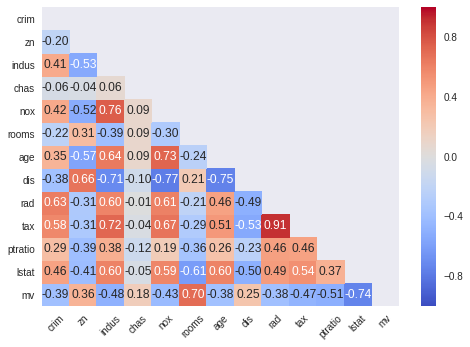

In [6]:
# corelation plot paramaters
def corr_plot(df_corr):
    corr = df_corr.corr()
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    sns.heatmap(boston_input.corr(), mask=top, cmap='coolwarm', annot=True, fmt=".2f")
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 0)
    plt.show()

corr_plot(boston_input)

In [7]:
boston_input.describe()

,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.528854
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.182176
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


**For each variable, a histogram plot shows the distribution of each observation in the original data. The variable 'rooms' and the response variable show fairly normal distrubtions, while the other variables show various levels of skewness **

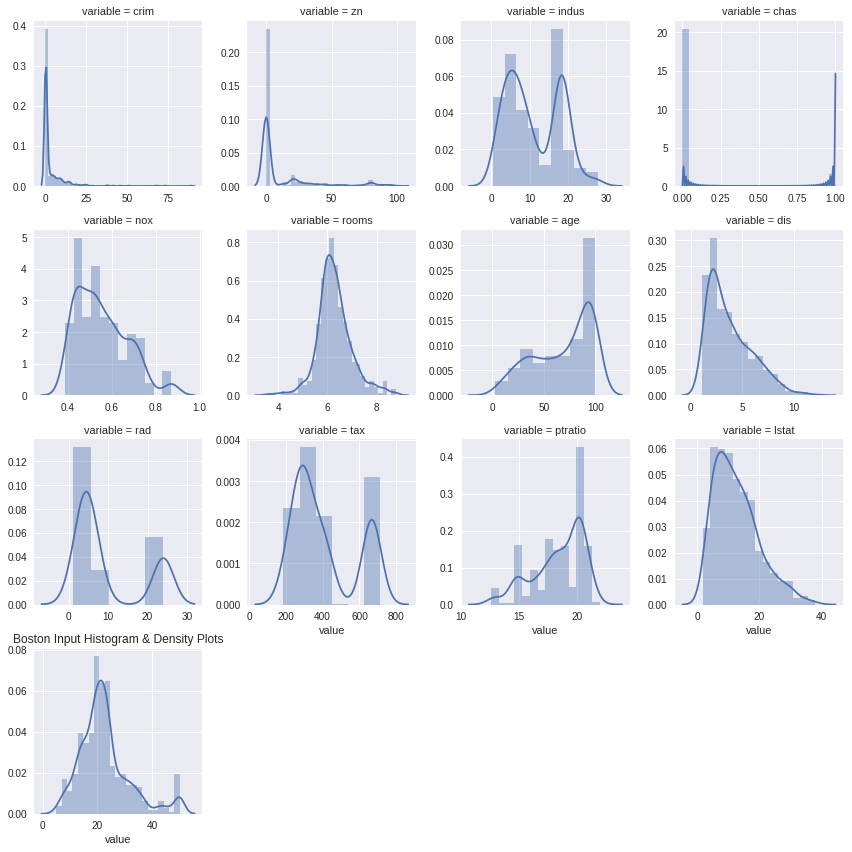

In [10]:
# historgram and density plot
def histogram_density_plots(data, dataname, title, features):
    d = data
    f = features
    g = pd.melt(d, value_vars = f)
    gm = sns.FacetGrid(g, col='variable', col_wrap = 4, sharex = False, sharey = False)
    gm = gm.map(sns.distplot, 'value')
    plt.title(title)
    plt.title(title)
    plt.savefig('Histogram-Density-{}.pdf'.format(dataname),
                bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b',
                orientation='portrait', papertype=None, format=None,
                transparent=True, pad_inches=0.25, frameon=None)
    plt.show()
    plt.close()

boston_features = ['crim', 'zn', 'indus', 'chas', 'nox', 'rooms', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat', 'mv']
histogram_density_plots(boston_input, 'Boston_Input', 'Boston Input Histogram & Density Plots',
                        boston_features)

**Create Scatter Plot Matrix of Continous Variables**

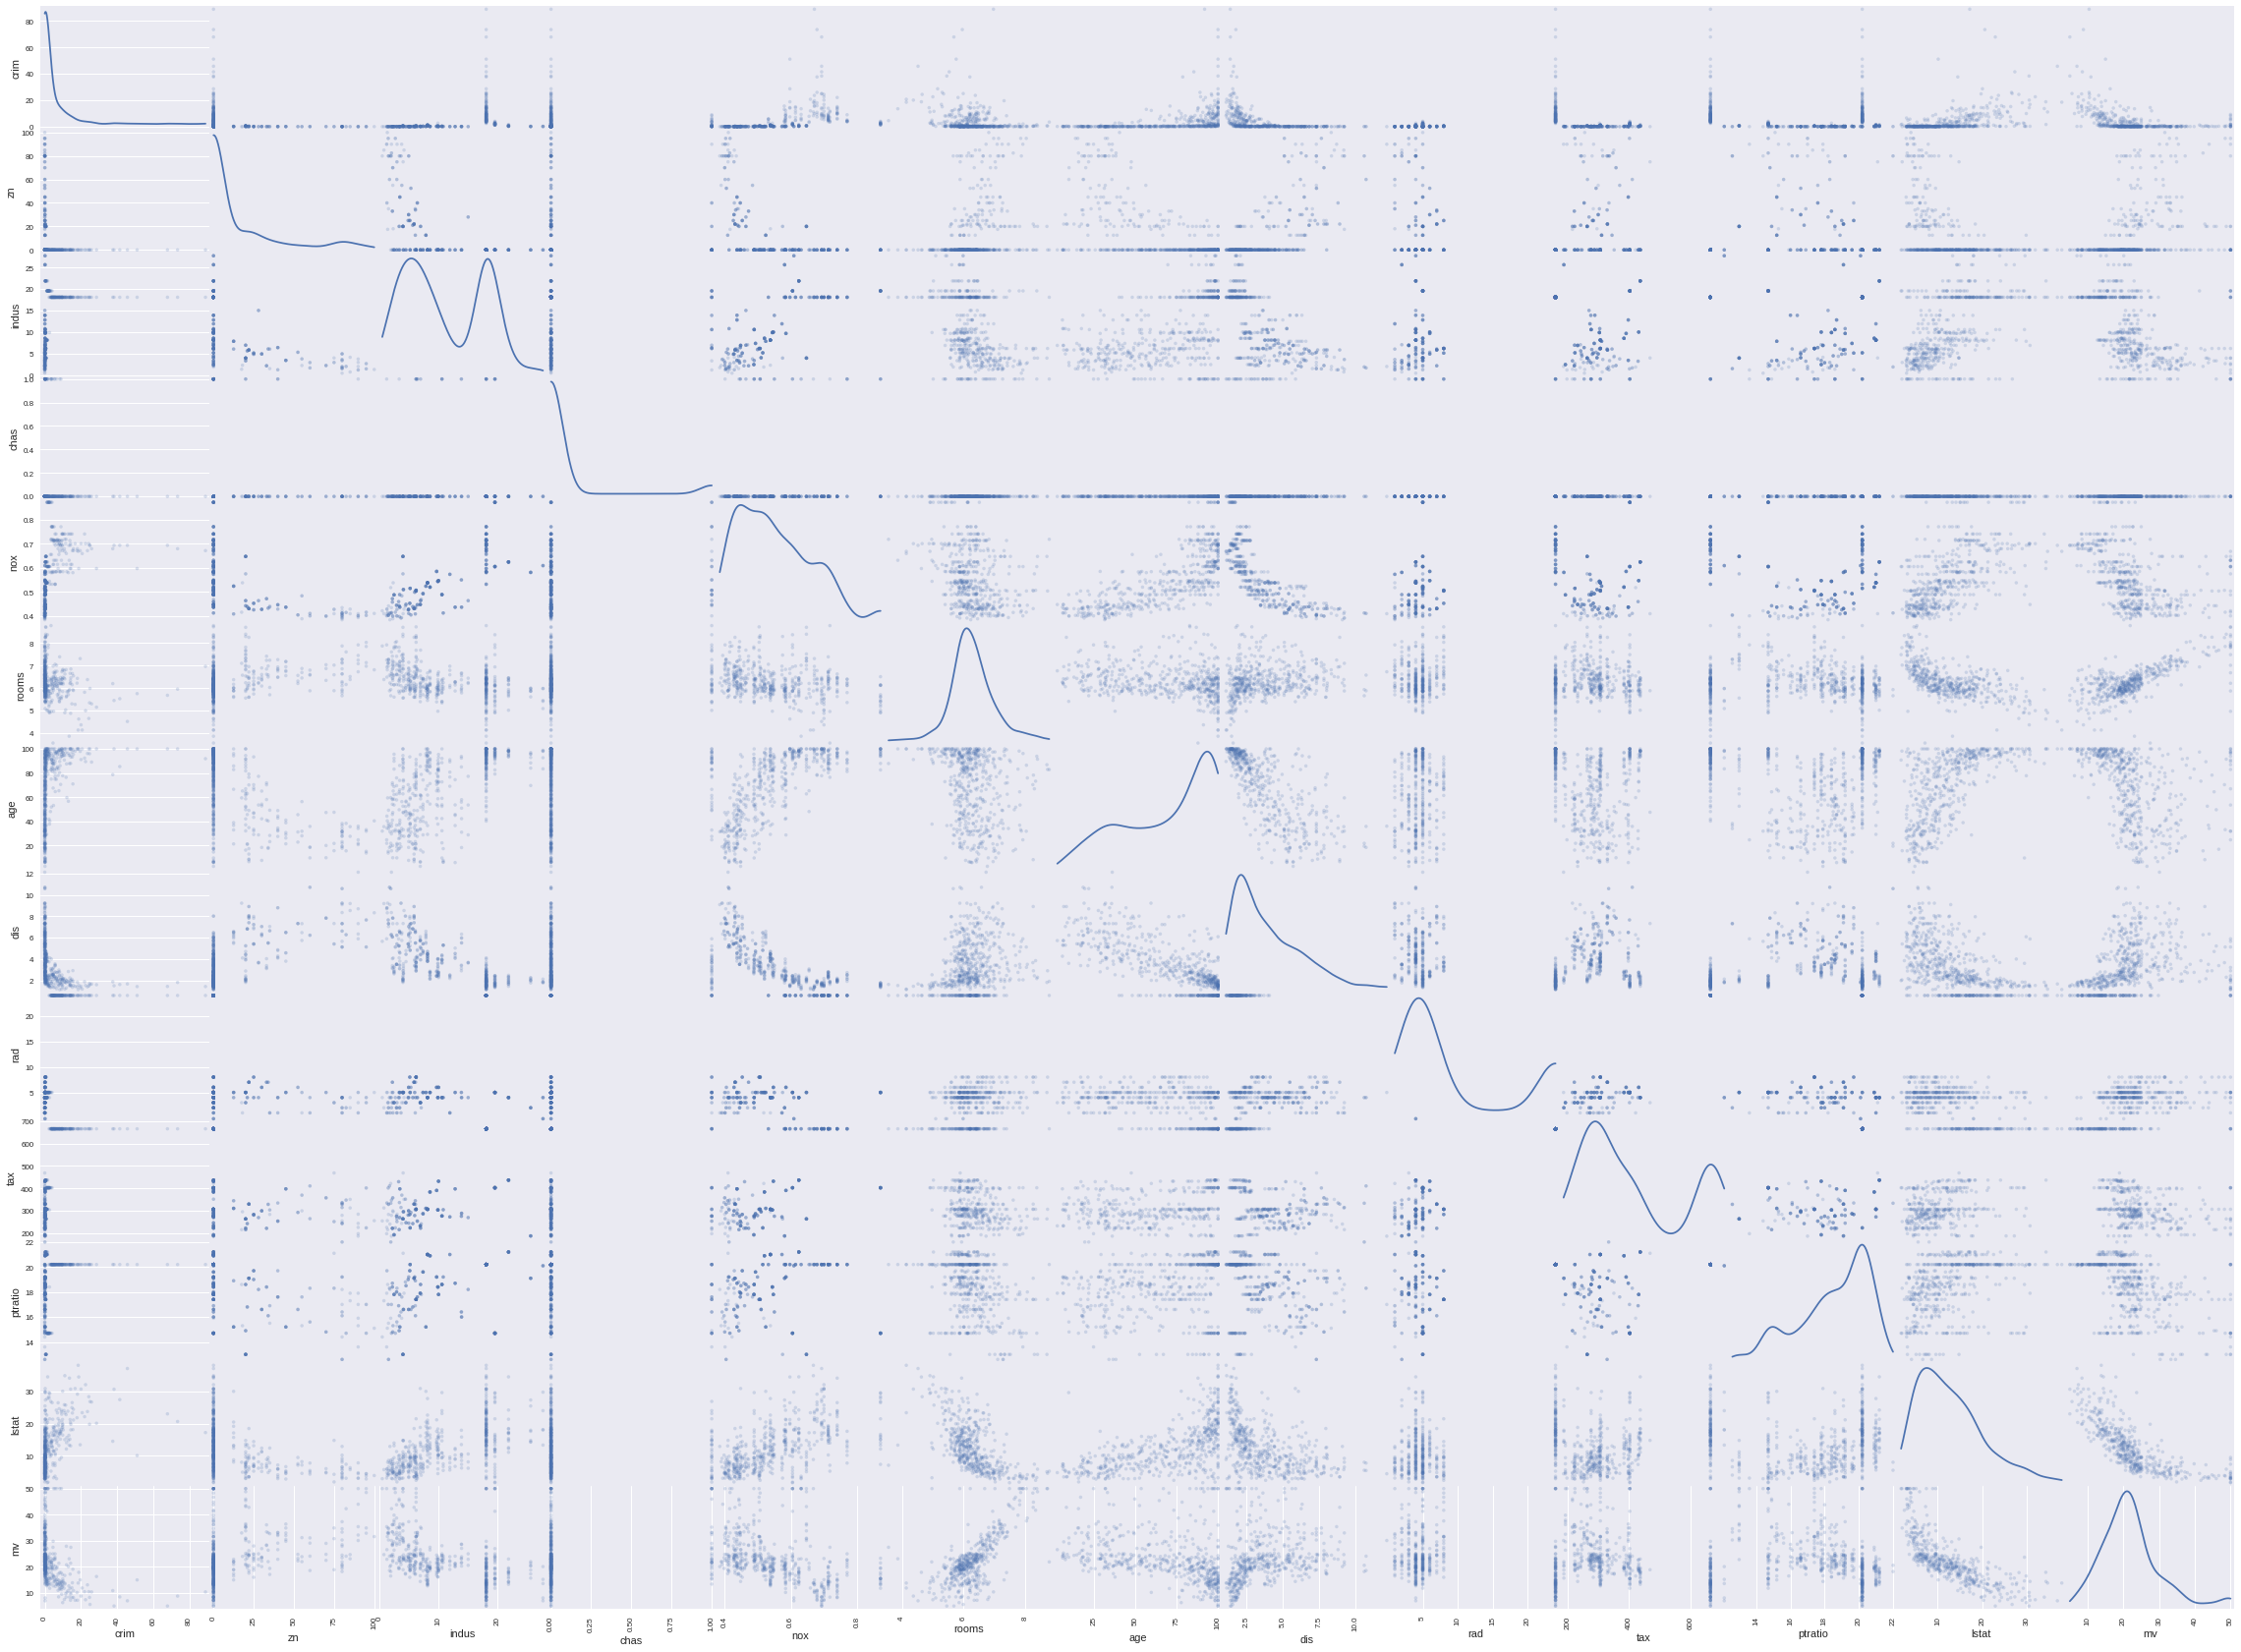

In [8]:
from pandas.plotting import scatter_matrix
scatter_matrix(boston_input, alpha = 0.2, figsize = (40, 30), diagonal = 'kde'); plt.show()

**The boxplots highlight the distributions and their outlying observations. Becasue the response variable presented a normal distribution in the histogram plots, removing outliers from the data was not explored**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


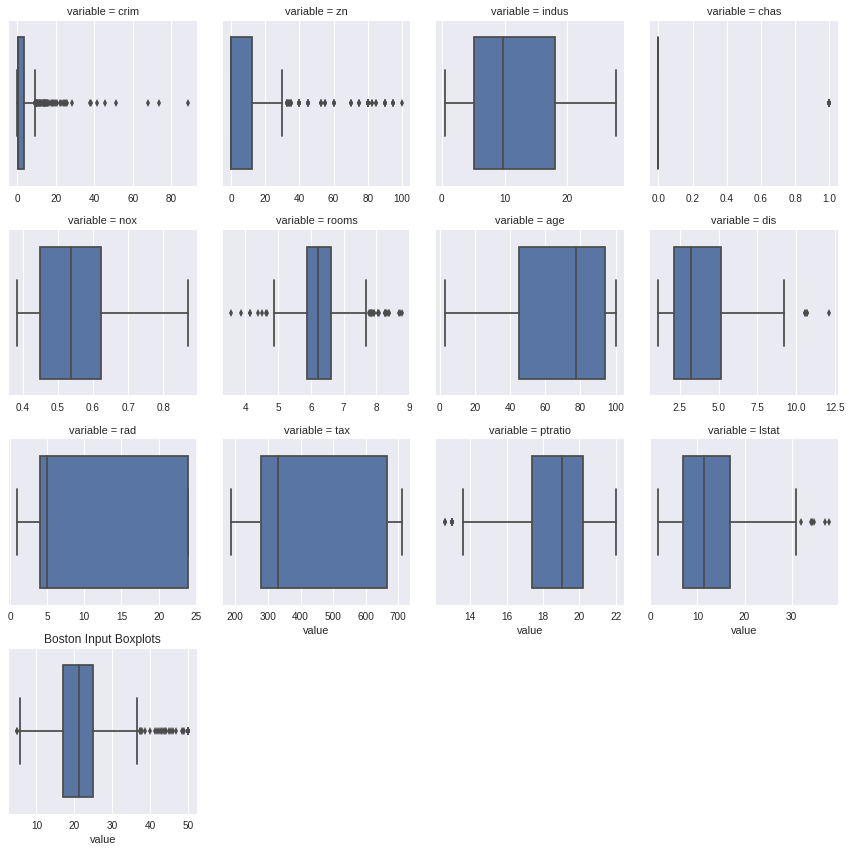

In [11]:
# boxplots
def create_box_plot(data, dataname, title, features):
    d = data
    f = features
    g = pd.melt(d, value_vars = f)
    gm = sns.FacetGrid(g, col='variable', col_wrap = 4, sharex = False, sharey = False)
    gm = gm.map(sns.boxplot, 'value')
    plt.title('Box Plot-{}-')
    plt.title(title)
    plt.savefig('Boxplot-{}.pdf'.format(dataname), 
                bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
                orientation='portrait', papertype=None, format=None, 
                transparent=True, pad_inches=0.25, frameon=None)
    plt.show()
    plt.close()

create_box_plot(boston_input, 'Boston_Input', 'Boston Input Boxplots',
        boston_features)

**The scatterplots show 1:1 variable relationships between each variable **

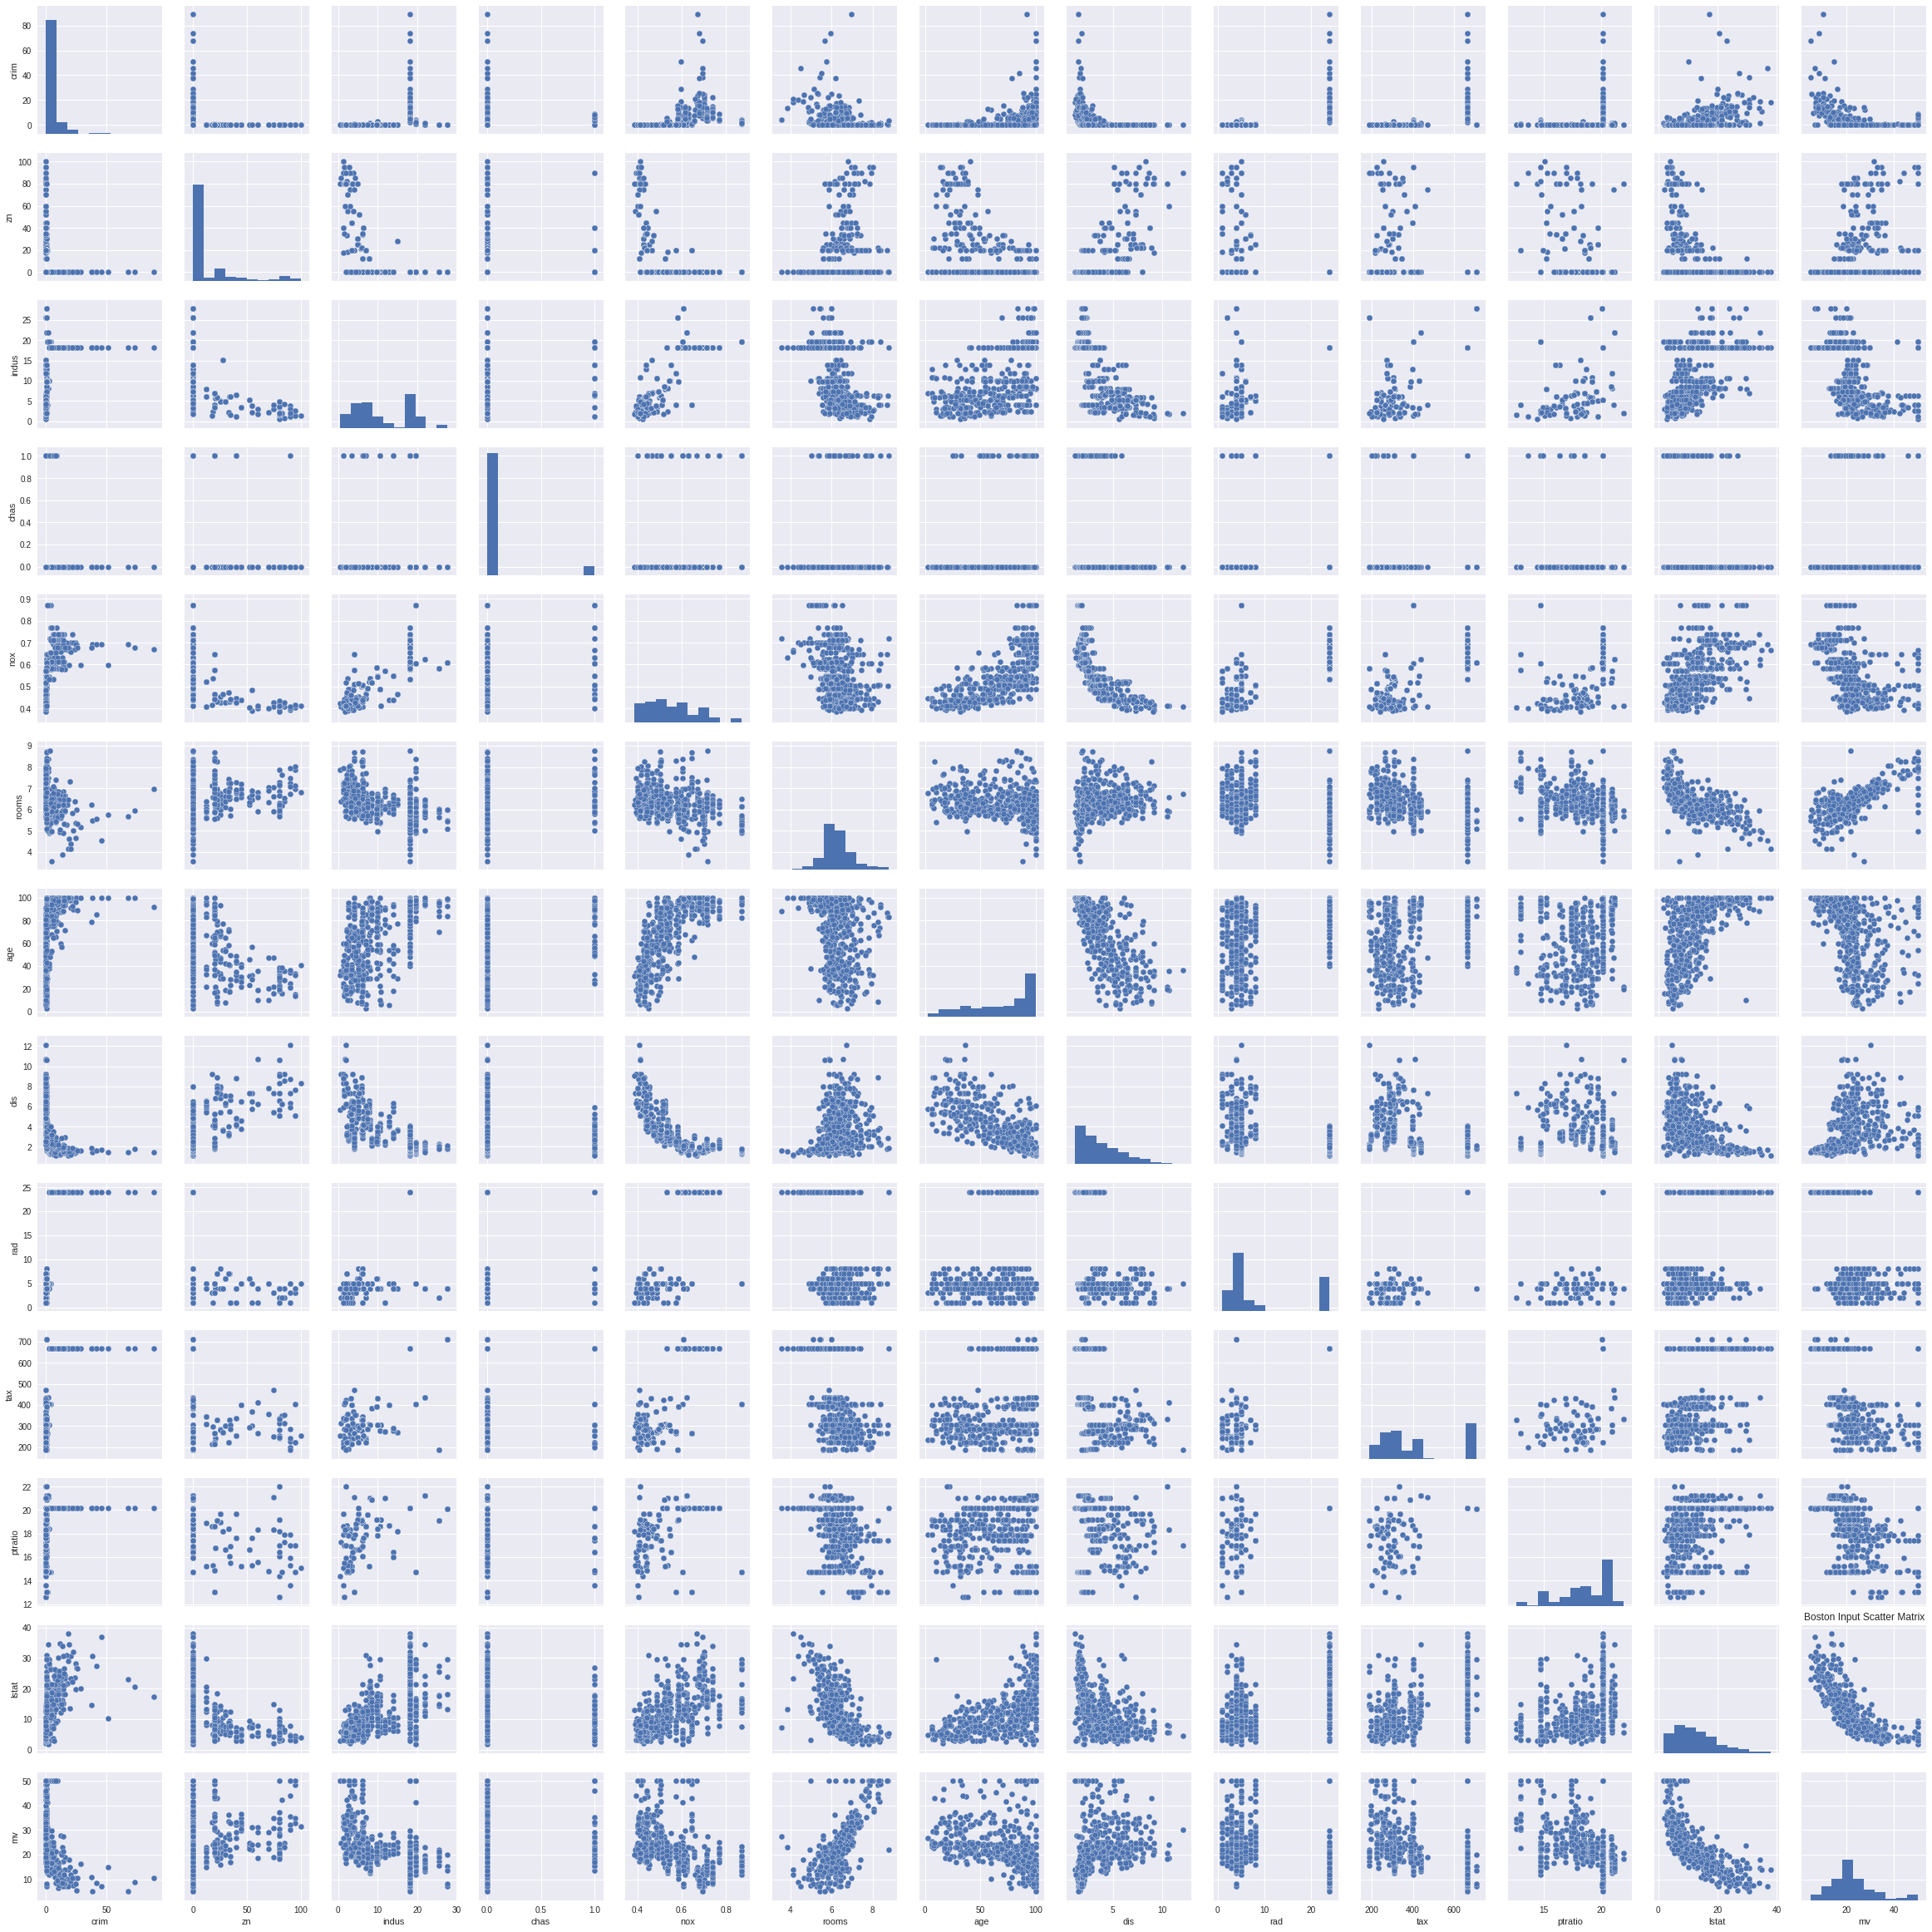

In [12]:
# create scatter plots
def create_scatter_matrix(data, dataname, title, features):
    d = data
    sns.pairplot(d)
    plt.title(title)

    plt.savefig('Scatte-Matrix-{}.pdf'.format(dataname), 
                bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
                orientation='portrait', papertype=None, format=None, 
                transparent=True, pad_inches=0.25, frameon=None)
    plt.show()
    plt.close()

create_scatter_matrix(boston_input, "Boston_Input", "Boston Input Scatter Matrix",
                      boston_features)

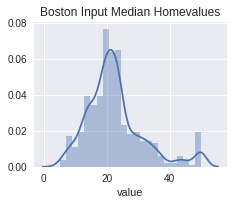

In [13]:
# histogram of features in boston_input
histogram_density_plots(boston_input, 'Boston', 'Boston Input Median Homevalues', 'mv')

**The categorical variable "neighborhood" is dropped from the observations **

In [0]:
# drop neighborhood variable
boston_model = boston_input.drop('neighborhood', 1)

# **Set up data for fitting regression models**

In [0]:
trans_model_data = np.array([np.log(boston_model.mv),\
   boston_model.crim,\
    boston_model.zn,\
    boston_model.indus,\
    boston_model.chas,\
    boston_model.nox,\
    boston_model.rooms,\
    boston_model.age,\
    boston_model.dis,\
    boston_model.rad,\
    boston_model.tax,\
    boston_model.ptratio,\
    boston_model.lstat]).T

## **Pre-standardization Histogram**

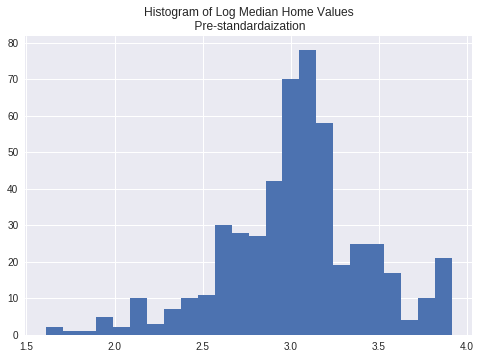

In [16]:
plt.hist(trans_model_data[:,0], bins = 'auto')
plt.title('Histogram of Log Median Home Values\n Pre-standardaization')
plt.savefig('Histogram_Log_Median_Home_Values.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)
plt.show()

In [17]:
# standard scores for the columns... along axis 0
scaler = StandardScaler()
print(scaler.fit(trans_model_data))

StandardScaler(copy=True, with_mean=True, with_std=True)


In [18]:
# show standardization constants being employed
print('\n Preliminary Model Data standardization constants:\n')
print(scaler.mean_)
print(scaler.scale_)


 Preliminary Model Data standardization constants:

[3.03455800e+00 3.61352356e+00 1.13636364e+01 1.11367787e+01
 6.91699605e-02 5.54695059e-01 6.28463439e+00 6.85749012e+01
 3.79504269e+00 9.54940711e+00 4.08237154e+02 1.84555336e+01
 1.26530632e+01]
[4.07871084e-01 8.59304135e+00 2.32993957e+01 6.85357058e+00
 2.53742935e-01 1.15763115e-01 7.01922514e-01 2.81210326e+01
 2.10362836e+00 8.69865112e+00 1.68370495e+02 2.16280519e+00
 7.13400164e+00]


**Fitting the data to a Standard Scaler shows a fair distribution of the response variable, log median home value **


Dimensions for model_data: (506, 13)


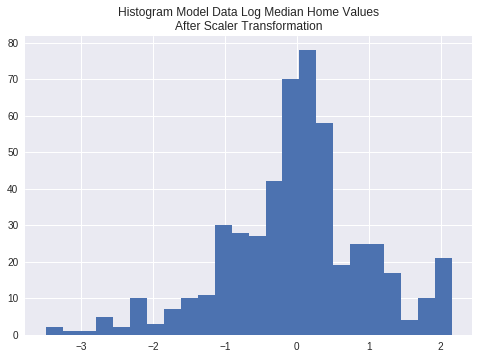

In [19]:
# the model data will be standardized form of preliminary model data
model_data = scaler.fit_transform(trans_model_data)
# dimensions of the polynomial model X input and y response
# all in standardized units of measure
print('\nDimensions for model_data:', model_data.shape)

plt.hist(model_data[:,0], bins = 'auto')
plt.title('Histogram Model Data Log Median Home Values\nAfter Scaler Transformation')
plt.savefig('Hist-Model-Data-Log-Median-Home-Values-After-Scaler-Transformation.pdf', 
    bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
    orientation='portrait', papertype=None, format=None, 
    transparent=True, pad_inches=0.25, frameon=None)
plt.show()

# **Regression Techniques**

**Setup** **regressors**

In [0]:
names = ['ElasticNet_Regression', 'Lasso_Regression','Linear_Regression', 
         'Ridge_Regression'] 

# list of regressors
regressors = [ElasticNet(alpha = 0.1, l1_ratio = 0.5, 
                          max_iter=10000, tol=0.01, 
                          fit_intercept = SET_FIT_INTERCEPT, 
                          normalize = False, 
                          random_state = RANDOM_SEED),
              Lasso(alpha = 0.1, max_iter=10000, tol=0.01, 
                     fit_intercept = SET_FIT_INTERCEPT, 
                     random_state = RANDOM_SEED),
              LinearRegression(fit_intercept = SET_FIT_INTERCEPT),
              Ridge(alpha = 1, solver = 'cholesky', 
                     fit_intercept = SET_FIT_INTERCEPT, 
                     normalize = False, 
                     random_state = RANDOM_SEED)]

### **Setup cross-validation design using 10 folds**


In [21]:
# N_FOLDS, intialized to 10 for ten-fold cross-validation
N_FOLDS = 10

# cv_results, numpy array, stores cross validation results
cv_results = np.zeros((N_FOLDS, len(names)))

# kf, sets up KFold 
kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = RANDOM_SEED)

# check the splitting process by looking at fold observation counts
index_for_fold = 0  # fold count initialized 
for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold)
#   the structure of modeling data for this study has the
#   response variable coming first and explanatory variables later          
#   so 1:model_data.shape[1] slices for explanatory variables
#   and 0 is the index for the response variable    
    X_train = model_data[train_index, 1:model_data.shape[1]]
    X_test = model_data[test_index, 1:model_data.shape[1]]
    y_train = model_data[train_index, 0]
    y_test = model_data[test_index, 0]   
    print('\nShape of input data for this fold:',
          '\nData Set: (Observations, Variables)')
    print('X_train:', X_train.shape)
    print('X_test:',X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:',y_test.shape)

    # variable index_for_method, initialize to zero
    index_for_method = 0 
    for name, reg_model in zip(names, regressors):
        print('\nRegression model evaluation for:', name)
        print('  Scikit Learn method:', reg_model)
        reg_model.fit(X_train, y_train)  # fit on the train set for this fold
        print('Fitted regression intercept:', reg_model.intercept_)
        print('Fitted regression coefficients:', reg_model.coef_)
 
        # evaluate on the test set for this fold
        y_test_predict = reg_model.predict(X_test)
        print('Coefficient of determination (R-squared):',
              r2_score(y_test, y_test_predict))
        fold_method_result = sqrt(mean_squared_error(y_test, y_test_predict))
        print(reg_model.get_params(deep=True))
        print('Root mean-squared error:', fold_method_result,
              '\n--------------------------------------------------------\n')
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
    
    index_for_fold += 1
    
# cv_results_df, pandas DataFrame, store cross validation results
cv_results_df = pd.DataFrame(cv_results)


Fold index: 0

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (455, 12)
X_test: (51, 12)
y_train: (455,)
y_test: (51,)

Regression model evaluation for: ElasticNet_Regression
  Scikit Learn method: ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=False, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=0.01, warm_start=False)
Fitted regression intercept: 0.013767835451315345
Fitted regression coefficients: [-0.14501515  0.         -0.          0.0409552  -0.0088081   0.17975848
  0.         -0.00801084 -0.         -0.07496835 -0.11567937 -0.47655932]
Coefficient of determination (R-squared): 0.7701951629768722
{'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 10000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': 42, 'selection': 'cyclic', 'tol': 0.01, 'warm_start': False}
Root mean-squared error: 0.3135510808

# **View average result from each regression technique**

**The evaluation metric, RMSE, is averaged from each of the 10 folds and used to compare the four models. Ridge and Linear Regression have the lowest error rates, while Elastic Net and Lasso have larger error rates**

In [22]:

pd.set_option('precision', 5)
print('\n----------------------------------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      'in standardized units (mean 0, standard deviation 1)\n',
      '\nMethod Root mean-squared error') 
print(cv_results_df.mean())   
with open("cv-results-df-mean.txt", "w") as text_file:
    text_file.write('\nAverage results from '+ str(N_FOLDS) + '-fold cross-validation\n'+
                    'in standardized units (mean 0, standard deviation 1)\n'+
                     '\nMethod Root mean-squared error:\n'+ 
                     str(cv_results_df.mean()))



----------------------------------------------
Average results from  10 -fold cross-validation
 in standardized units (mean 0, standard deviation 1)
 
Method Root mean-squared error
0    0.51885
1    0.54441
2    0.49645
3    0.49569
dtype: float64
